# Progress Report I

### Team Member: Woo Min Kim, Shen Yan 
### Papar Selected: Stochastic Gradient Hamiltonian Monte Carlo

## A brief description of the algorithm: 



In Hamiltonian Monte Carlo sampling algorithm, one can define a Hamiltonian given the target distribution. By letting the state points evolve according to the Hamiltonian dynamics, the state space can be efficiently explored. However, Hamiltonian Monte Carlo requires the computation of the gradient of the target distribution, and when facing with problems with large data set, such computation can become infeasible. Stichastic Gradient Hamiltonian Monte Carlo addresses this problem by using only a minibatch of the data set to compute the gradient. This approximation scheme will bring extra noise to the result, and unfortunately a naive implementation of the stochastic approximation will render the algorithm unable to converge the desired distribution. By introducing a friction term in evolution equations, which turns the dynamics into the second-order Langevin dynamics, this term would magically offset the noise caused by the stochastic approximation, and the algorithm would converge to the target distribution.  <br\>

## Progress so far

We first wrote a version of SGHMC which can only sample one-dimensional random variables. As a simple illustration, We tested it by sampling from a distribution described in the paper, with $U(\theta) = -2\theta^2 + \theta^4$. Then we extend this version to include multi-dimensional random variables, and tested it by sampling from a multivariate normal distribution. So far, we have only optimized the code by trying to write everything in a more pythonic style. Before any further optimization, we tested our sampling algorithm by doing Bayesian logistic regression on a simulated data set, as well as WPBC data set from UCI Machine Learning Repository. For all the tests above, we have written a HMC algorithm to compare. <br\>

### Stochastic Gradient Hamiltonian Monte Carlo for one-dimensional random variables

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [4]:
def sghmc_scalar(U, gradU, m, dt, nstep, x, C, V):
    p = np.random.randn() * np.sqrt(m)
    B = 0.5 * dt * V
    D = np.sqrt(2. * (C-B) * dt)
    for i in range(nstep):
        p += -gradU(x) * dt - p * C * (1./m) * dt + np.random.randn() * D
        x += p/m * dt
    return x

For comparison, we also coded a Hamiltonian Monte Carlo for one-dimensional random variables

In [5]:
def hmc_scalar(U, gradU, m, dt, nstep, x):
    p = np.random.randn() * np.sqrt(m)
    oldX = x
    oldEnergy = p * (1./m) * p / 2 + U(x)
    for i in range(nstep):
        p -= gradU(x) * dt/2.
        x += p/m * dt
        p -= gradU(x) * dt/2.
    newEnergy = p * (1./m) * p / 2 + U(x)
    if np.random.random() > np.exp(oldEnergy - newEnergy): # Metropolis-Hastings
        x = oldX
    return x

To test the algorithms, we used them on the following $U$.

In [6]:
def U(x):
    return -2. * x**2 + x**4

def gradU_scalar(x):
    return -4. * x + 4. * x**3 + np.random.randn() * 2.

def gradU_perfect(x):
    return -4. * x + 4. * x**3

Below is the shape of the target distribution

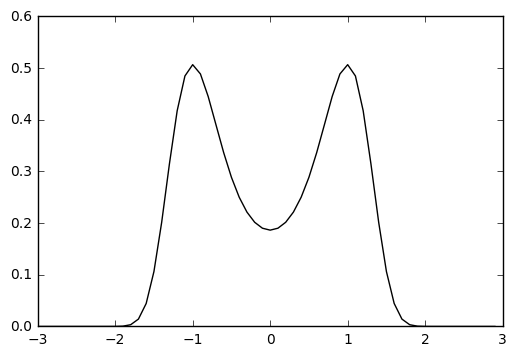

In [8]:
xStep = 0.1
xGrid = np.arange(-3., 3., xStep)
y = np.exp( - U(xGrid) )
y = y / (np.sum(y) * xStep)
plt.plot(xGrid,y, '-k')


Testing SGHMC

In [9]:
nsample = 80000
xStep = 0.1
m = 1.
C = 3.
dt = 0.1
nstep = 50
V = 4.

In [10]:
samples = np.zeros(nsample)
x = 0.
for i in range(nsample):
    x = sghmc_scalar( U, gradU_scalar, m, dt, nstep, x, C, V )
    samples[i] = x

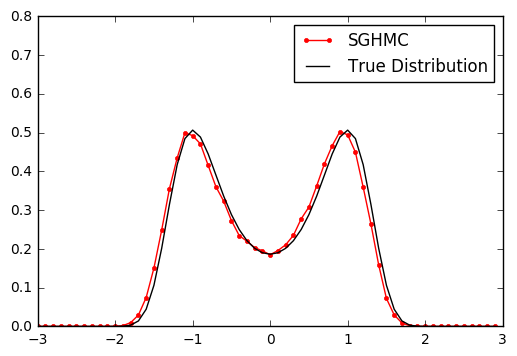

In [11]:
yshmc = scipy.stats.histogram(samples, numbins=len(xGrid), defaultlimits=(-3.,3.))[0]
yshmc = yshmc / (np.sum(yshmc) * xStep)

plt.plot(xGrid,yshmc, '.-r', label='SGHMC')
plt.plot(xGrid,y, '-k', label='True Distribution')
plt.ylim(0.0,0.8)
plt.legend()

Testing HMC

In [12]:
samples = np.zeros(nsample)
x = 0.
for i in range(nsample):
    x = hmc_scalar( U, gradU_scalar, m, dt, nstep, x )
    samples[i] = x

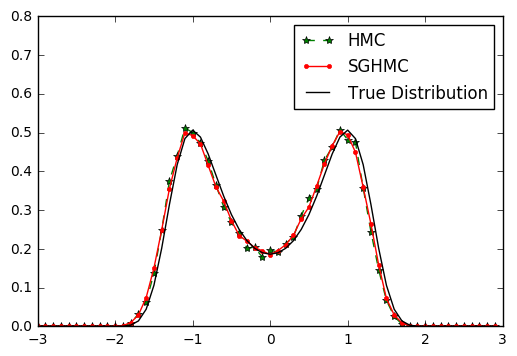

In [13]:
yhmc = scipy.stats.histogram(samples, numbins=len(xGrid), defaultlimits=(-3.,3.))[0]
yhmc = yhmc / (np.sum(yhmc) * xStep)

plt.plot(xGrid,yhmc, '*--g', label='HMC')
plt.plot(xGrid,yshmc, '.-r', label='SGHMC')
plt.plot(xGrid,y, '-k', label='True Distribution')
plt.ylim(0.0,0.8)
plt.legend()

### Stochastic Gradient Hamiltonian Monte Carlo for Multi-dimensional random variables

According to the paper, we code the SGHMC in a slightly different way which is easier for tuning parameters.

In [18]:
def sghmc_vectorNew(gradU, eta, L, alpha, x, V):
    beta = 0.5 * V * eta
    p = np.random.randn(len(x)) * np.sqrt( eta )
    momentum = 1. - alpha
    try:
        sigma = np.sqrt( 2. * eta * (alpha-beta) )
    except:
        print('eta too big')
    for i in range(L):
        p = p * momentum - gradU( x ) * eta + np.random.randn(len(p)) * sigma
        x += p
    return x.copy()

We tested this algorithm on a multivariate normal distribution(2-dimensional)

In [19]:
def U(x):
    sigma = np.array([[1.,0.9],[0.9,1.]])
    return 0.5 * x.dot( np.linalg.solve(sigma,x))

def gradU_vector(x):
    mean = np.zeros_like(x)
    sigma = np.array([[1.,0.9],[0.9,1.]])
    return np.linalg.solve(sigma,x) + np.random.randn(len(x))

In [20]:
xGrid = np.linspace(-2., 3., 200)
yGrid = np.linspace(-2., 3., 200)

XGrid, YGrid = np.meshgrid(xGrid, yGrid)

Z = np.zeros((xGrid.shape[0], yGrid.shape[0]))
for i in range(xGrid.shape[0]):
    for j in range(yGrid.shape[0]):
        Z[i,j] = np.exp(-U(np.array([xGrid[i],yGrid[j]])))

In [21]:
nsample = 8000
V = 1
etaSGHMC = 0.05
alpha = 0.035
L = 50

In [22]:
samples = []
x = np.array([0.,0.])
for i in range(nsample):
    x = sghmc_vectorNew( gradU_vector, etaSGHMC, L, alpha, x, V )
    samples.append(x.copy())

(-2, 3)

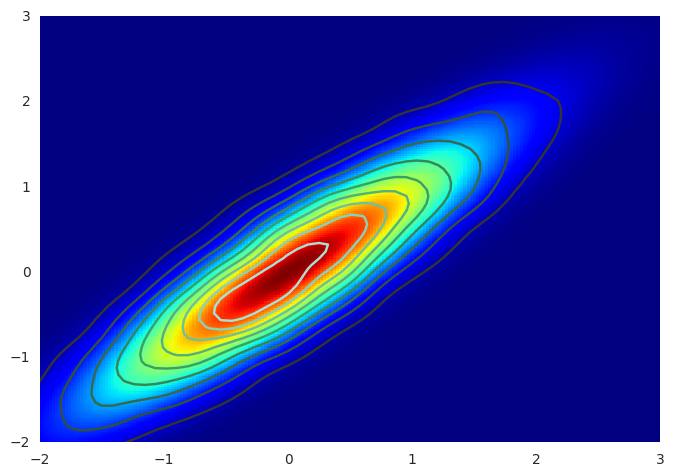

In [23]:
import seaborn as sns

samples = np.array(samples)

plt.pcolor(XGrid, YGrid, Z, cmap='jet')
sns.kdeplot(samples[:,0],samples[:,1])
plt.xlim(-2,3)
plt.ylim(-2,3)

The background colormap indicates the probability density distribution of the true distribution, the contour plot is the kernel density estimation of the samples sampled from SGHMC

We have other results, but to save space we will not show them in this report.

## Next Step

We will optimize the code by doing a problem-specific optimization. Since SGHMC depends on $U$ and $gradU$, it is not easy to optimize SGHMC generally so that it works for any $U$ or $gradU$. We decided that since the most computation-costly steps are actually computing $U$ and $gradU$, it is more reasonable to optimize $U$ and $gradU$ for a specific problem. Here we will optimize these functions for Bayesian logistic regression. We are in the middle of warpping these functions in c++, and we will compare the c++ version with the original function.